In [15]:
# import all the necessary packages

import os
import sys
import random
import warnings
from pylab import imshow, show, get_cmap

#packages for tensor and array calculations
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
 #tqdm is used for displaying a progress bar 
from tqdm import tqdm

from itertools import chain

#keras package along with tensroflow backend for deep learning
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, UpSampling2D, Flatten, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras import backend as K
import tensorflow as tf

#images display and basic operations
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [16]:
#dimensions of the image to be processed and compressed

IMG_WIDTH = 96
IMG_HEIGHT = 64
IMG_CHANNELS = 1
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
TRAIN_PATH = 'data/'

In [17]:
#diplaying names of images
train_ids = next(os.walk(TRAIN_PATH))[2]
train_ids[:10]

['0.png',
 '1.png',
 '10.png',
 '100.png',
 '1000.png',
 '1001.png',
 '1002.png',
 '1003.png',
 '1004.png',
 '1005.png']

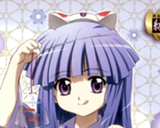

In [18]:
#sample image
Image.open(TRAIN_PATH + '10.png')

In [21]:
print(len(train_ids))

9754


In [23]:

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')


In [24]:
print(X_train.shape)

(9754, 64, 96, 1)


In [25]:

# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
final_train_ids = []
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH +str(n+1) + '.png'
    try:
        img = imread(path)
        img = img.astype('float32') / 255.
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
        print(" Problem with: "+path)
        missing_count += 1
        
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|████████████████████████████████████████████████████████████████████████████▊| 9738/9754 [00:44<00:00, 223.34it/s]

 Problem with: data/9754.png


100%|█████████████████████████████████████████████████████████████████████████████| 9754/9754 [00:44<00:00, 218.02it/s]


Total missing: 1


In [26]:
def Encoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    return Model(inp, encoded)

encoder = Encoder()
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 96, 1)         0         
_________________________________________________________________
encode1 (Conv2D)             (None, 64, 96, 128)       2176      
_________________________________________________________________
encode2 (Conv2D)             (None, 64, 96, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 48, 64)        0         
_________________________________________________________________
encode3 (Conv2D)             (None, 32, 48, 64)        36928     
_________________________________________________________________
encode4 (Conv2D)             (None, 32, 48, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 24, 32)        0         
__________

In [27]:
D_INPUT_SHAPE=[128]
def Decoder():
    inp = Input(shape=D_INPUT_SHAPE, name='decoder')
    x = Dense(256, activation='elu', name='decode1')(inp)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

decoder = Decoder()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder (InputLayer)         (None, 128)               0         
_________________________________________________________________
decode1 (Dense)              (None, 256)               33024     
_________________________________________________________________
decode2 (Dense)              (None, 768)               197376    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 6, 32)          0         
_________________________________________________________________
decode3 (Conv2D)             (None, 4, 6, 32)          4128      
_________________________________________________________________
decode4 (Conv2D)             (None, 4, 6, 64)          18496     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 12, 64)         0         
__________

In [36]:
from keras.layers import LeakyReLU
def Autoencoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    x = Dense(256, activation='elu', name='decode1')(encoded)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)


#     x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
#     x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
#     x = Conv2DTranspose(64, (3,3),padding='same')(x)
#     x = LeakyReLU()(x)
#     x = UpSampling2D((2, 2))(x)
#     x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
#     x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
#     x = Conv2DTranspose(64, (3,3),padding='same')(x)
#     x = LeakyReLU()(x)
#     x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

model = Autoencoder()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 96, 1)         0         
_________________________________________________________________
encode1 (Conv2D)             (None, 64, 96, 128)       2176      
_________________________________________________________________
encode2 (Conv2D)             (None, 64, 96, 64)        73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 48, 64)        0         
_________________________________________________________________
encode3 (Conv2D)             (None, 32, 48, 64)        36928     
_________________________________________________________________
encode4 (Conv2D)             (None, 32, 48, 32)        8224      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 24, 32)        0         
__________

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Dancer_Auto_Model.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=8,
                              verbose=1,
                              mode='min',
                              restore_best_weights=True)

In [38]:
class ImgSample(Callback):

    def __init__(self):
       super(Callback, self).__init__() 

    def on_epoch_end(self, epoch, logs={}):
        sample_img = X_train[50]
        sample_img = sample_img.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
        sample_img = self.model.predict(sample_img)[0]
        imshow(sample_img.reshape(64,96))
        plt.show()

imgsample = ImgSample()

Train on 9266 samples, validate on 488 samples
Epoch 1/30
 - 71s - loss: 0.0398 - val_loss: 0.0257


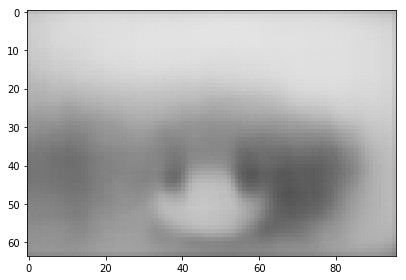

Epoch 2/30
 - 71s - loss: 0.0227 - val_loss: 0.0210


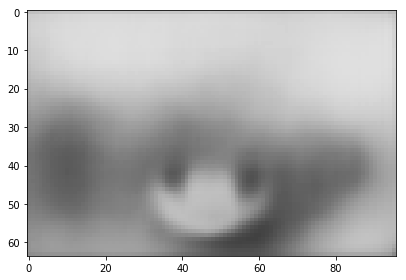

Epoch 3/30
 - 70s - loss: 0.0189 - val_loss: 0.0185


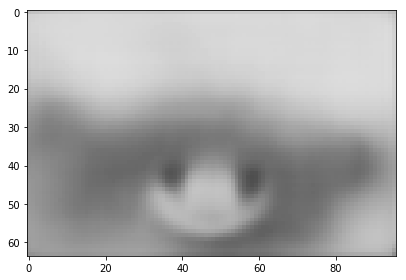

Epoch 4/30
 - 69s - loss: 0.0173 - val_loss: 0.0169


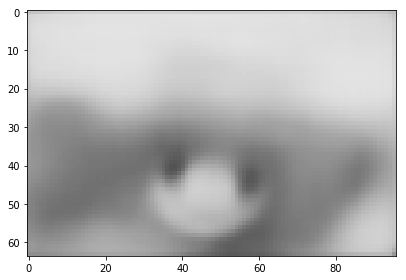

Epoch 5/30
 - 69s - loss: 0.0163 - val_loss: 0.0166


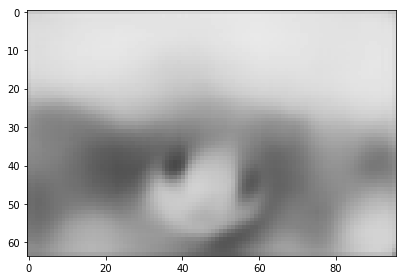

Epoch 6/30
 - 69s - loss: 0.0156 - val_loss: 0.0159


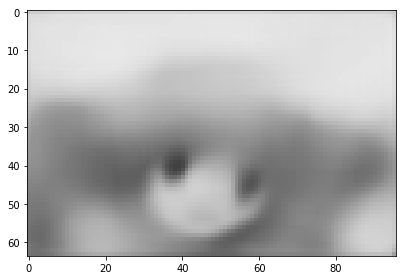

Epoch 7/30
 - 70s - loss: 0.0150 - val_loss: 0.0156


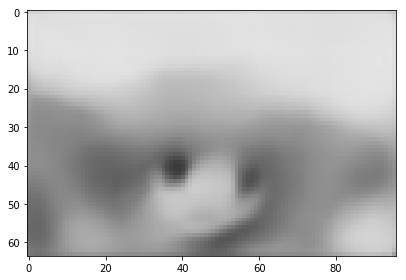

Epoch 8/30
 - 70s - loss: 0.0147 - val_loss: 0.0149


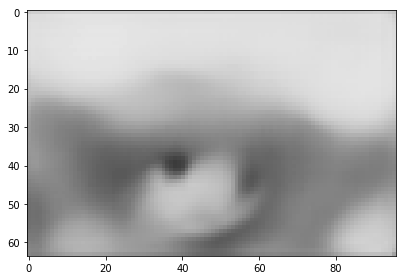

Epoch 9/30
 - 70s - loss: 0.0142 - val_loss: 0.0146


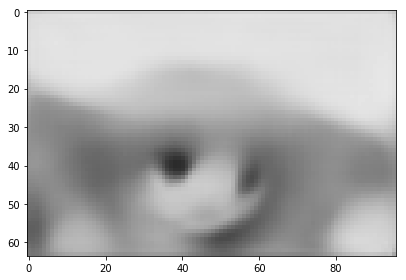

Epoch 10/30
 - 69s - loss: 0.0139 - val_loss: 0.0148


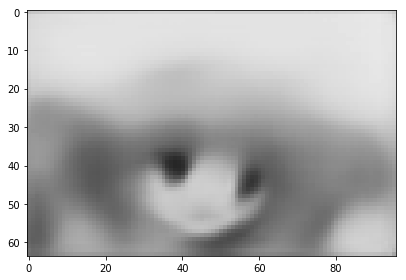

Epoch 11/30
 - 70s - loss: 0.0136 - val_loss: 0.0139


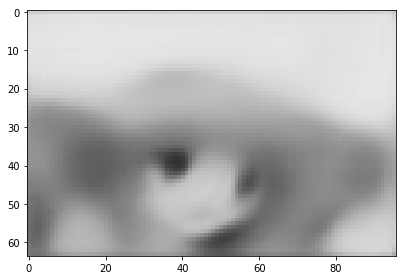

Epoch 12/30
 - 70s - loss: 0.0135 - val_loss: 0.0141


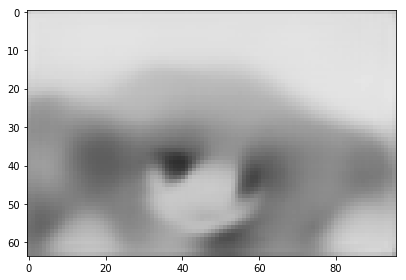

Epoch 13/30
 - 70s - loss: 0.0132 - val_loss: 0.0140


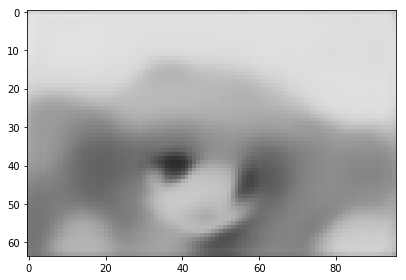

Epoch 14/30
 - 70s - loss: 0.0131 - val_loss: 0.0134


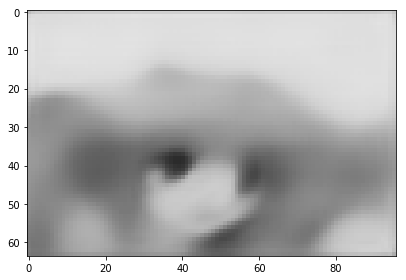

Epoch 15/30
 - 70s - loss: 0.0129 - val_loss: 0.0138


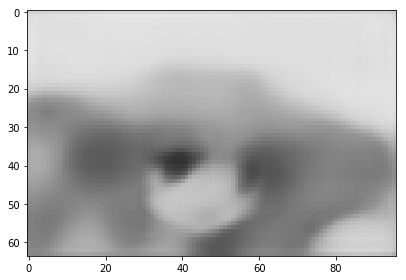

Epoch 16/30
 - 70s - loss: 0.0130 - val_loss: 0.0132


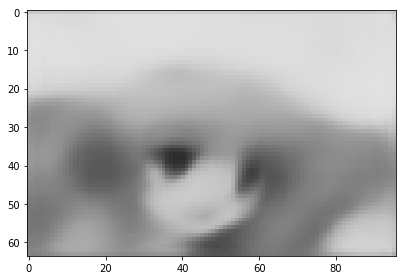

Epoch 17/30
 - 70s - loss: 0.0125 - val_loss: 0.0130


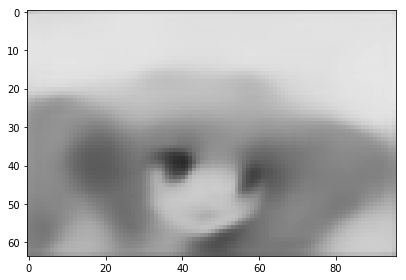

Epoch 18/30
 - 70s - loss: 0.0124 - val_loss: 0.0130


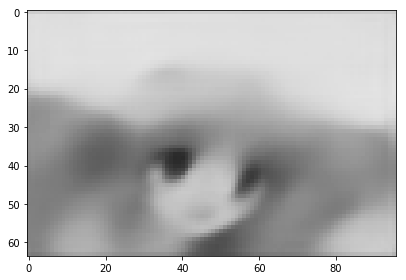

Epoch 19/30
 - 70s - loss: 0.0124 - val_loss: 0.0130


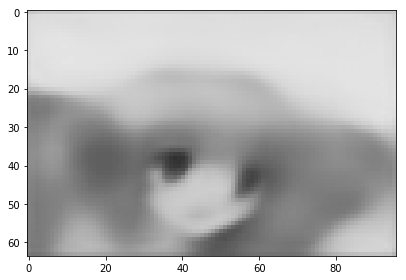

Epoch 20/30
 - 70s - loss: 0.0121 - val_loss: 0.0132


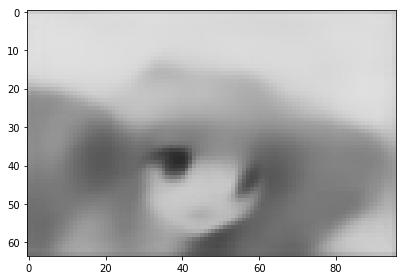

Epoch 21/30
 - 70s - loss: 0.0121 - val_loss: 0.0127


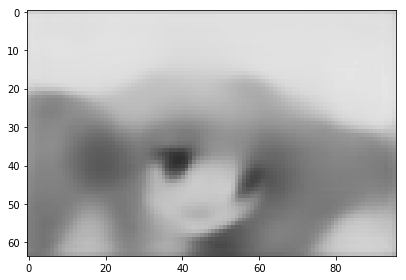

Epoch 22/30
 - 70s - loss: 0.0120 - val_loss: 0.0125


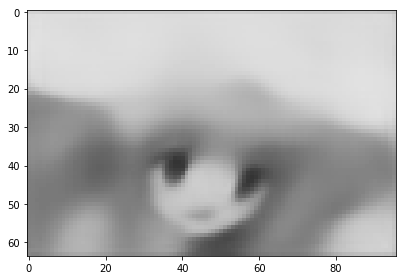

Epoch 23/30
 - 70s - loss: 0.0120 - val_loss: 0.0124


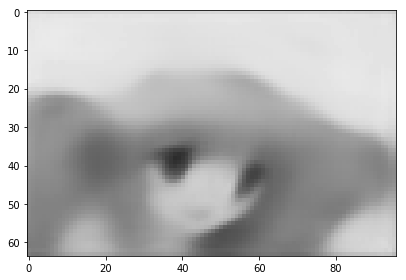

Epoch 24/30
 - 70s - loss: 0.0117 - val_loss: 0.0125


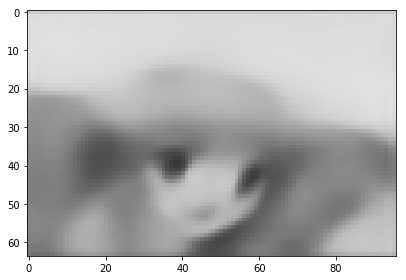

Epoch 25/30
 - 70s - loss: 0.0117 - val_loss: 0.0127


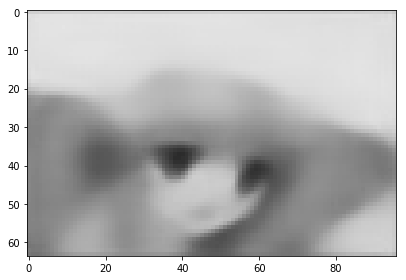

Epoch 26/30
 - 70s - loss: 0.0116 - val_loss: 0.0124


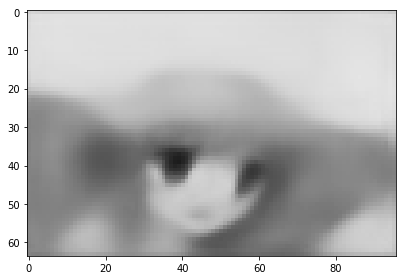

Epoch 27/30
 - 70s - loss: 0.0116 - val_loss: 0.0123

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


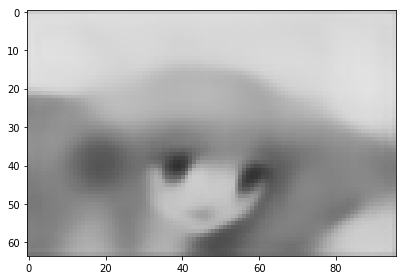

Epoch 28/30
 - 70s - loss: 0.0108 - val_loss: 0.0115


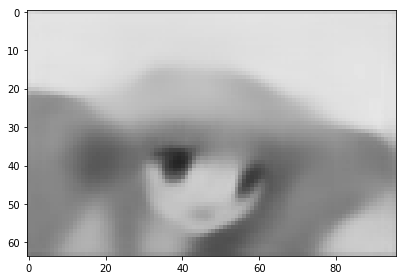

Epoch 29/30
 - 70s - loss: 0.0107 - val_loss: 0.0116


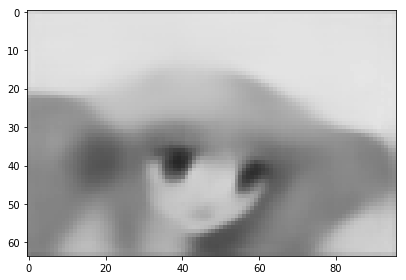

Epoch 30/30
 - 70s - loss: 0.0107 - val_loss: 0.0115


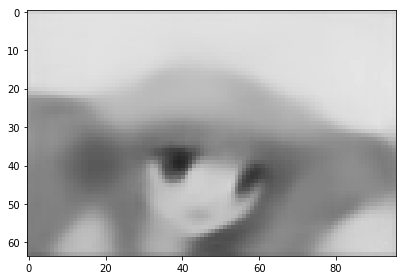

In [39]:
model.fit(X_train, X_train,
          epochs=30, 
          batch_size=32,
          verbose=2,
          validation_split=0.05,
        callbacks=[learning_rate_reduction, checkpoint, early_stopping, imgsample])

In [40]:
decoded_imgs = model.predict(X_train)

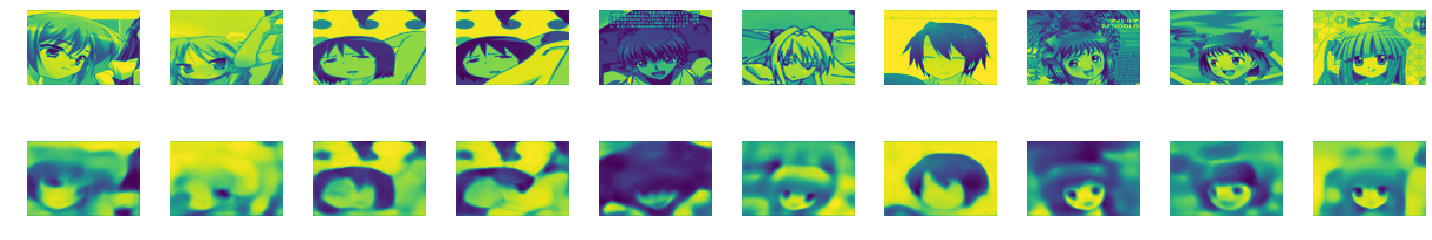

In [41]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # original
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[i].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
 
    # reconstruction
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

In [42]:
model.save_weights("compressor_Auto_Weights.hdf5")

In [43]:
encoder = Encoder()
decoder = Decoder()

encoder.load_weights("compressor_Auto_Weights.hdf5", by_name=True)
decoder.load_weights("compressor_Auto_Weights.hdf5", by_name=True)

model.save('Compressor_Auto_Model.hdf5') 
decoder.save('Decoder_Model.hdf5') 
encoder.save('Encoder_Model.hdf5')
model.save_weights("compressor_Auto_Weights.hdf5")
decoder.save_weights("Decoder_Weights.hdf5")
encoder.save_weights("Encoder_Weights.hdf5")